# Marking up [WiderFace](http://shuoyang1213.me/WIDERFACE/) dataset by gender

We have all WiderFace **images** and some .mat files with **metadata** of these images. We need to **mark up these images by gender**. We should do these next **steps**: 
1. **Separate** easy-scale images to individual folder
2. **Mark up** these easy-scale images by gender
3. **Crop** faces from these images
4. **Create** file: face, gender

In [1]:
from scipy import io
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from shutil import copyfile, rmtree 
from IPython.display import clear_output
import pandas as pd 
import ast

In [2]:
path_to_train_mat = 'WiderFacesDataset/wider_face_train.mat'
path_to_val_mat = 'WiderFacesDataset/wider_face_val.mat'
path_to_all_images = 'WiderFacesDataset/All/'
path_to_train_easy_scale_images = 'WiderFacesDataset/EasyScaleImages/Train/'
path_to_val_easy_scale_images = 'WiderFacesDataset/EasyScaleImages/Val/'
path_to_gender_marks = 'WiderFacesDataset/EasyScaleMarkedUpGender/'

In [3]:
train_mat = io.loadmat(path_to_train_mat)
val_mat = io.loadmat(path_to_val_mat)

In [4]:
# Names of easy-scale image folder 
easy_names = ['Gymnastics', 'Handshaking', 'Waiter', 'Conference',
                'Worker', 'Parachutist', 'Coach', 'Meeting',
                'Aerobics', 'Boat', 'Dancing', 'Swimming', 
                'Family', 'Balloonist', 'Dresses', 'Couple', 
                'Jockey', 'Tennis', 'Spa', 'Surgeons']

## Separate easy-scale images from all

In [5]:
# Get paths to all easy-scale images
def get_easy_scale_images(mat):    
    file_list = mat['file_list']
    
    # Get easy-scale folders number
    def get_easy_folders(easy_names=easy_names):
        easy_folders = []        
        for name in easy_names:
            for i in range(0, len(file_list)):
                if (name in file_list[i][0][0][0][0]):
                    easy_folders.append(i)
        return easy_folders
    
    images = []
    easy_folders = get_easy_folders()
    for easy_folder in easy_folders:
        folder = file_list[easy_folder]
        for name in folder[0]:
            images.append(name[0][0] + ".jpg")
            
    return images

In [6]:
# Replace easy-scale images to other dirs
def separate_easy_scale_part():
    
    def replace(mat, path):
        images_names = get_easy_scale_images(mat)    
        for name in images_names:
            image_path = path_to_all_images + name
            destination_path = path + name
            copyfile(image_path, destination_path)

    # 1 - Train images
    replace(train_mat, path_to_train_easy_scale_images)    
    # 2 - Validation images    
    replace(val_mat, path_to_val_easy_scale_images)

In [7]:
# separate_easy_scale_part()

In [8]:
def convert2RGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [9]:
def get_nums_of_image(mat, name):
    folder_num = -1 
    file_num = -1
    for folder in mat['file_list']:
        folder_num += 1
        file_num = -1
        for file_name in folder[0]:
            file_num += 1
            name_ = file_name[0][0]
            if (name_ + '.jpg' == name):
                # print(f"Folder: {folder_num} \nFile: {file_num}")
                return folder_num, file_num

In [10]:
def get_boxes(mat, folder, file):
    return mat['face_bbx_list'][folder][0][file][0]

In [11]:
def display_faces(img_copy, crop_image):
    fig=plt.figure(figsize=(15, 15))
    fig.add_subplot(1, 2, 1)
    plt.imshow(convert2RGB(img_copy))
    plt.axis('off')
    plt.tight_layout()

    fig.add_subplot(1, 2, 2)
    plt.imshow(convert2RGB(crop_image))
    plt.axis('off')
    plt.tight_layout()

    plt.show(block=False)

In [12]:
def digit2gender(digit):
    if digit == 2:
        return 'f'
    if digit == 1:
        return 'm'
    else:
        return 'skip'

In [13]:
def gender2digit(gender):    
    if gender == '':
        return -1    

    clean_gender = gender.lower().strip()[0]
    if clean_gender == 'm':
        return 1
    if clean_gender == 'f':
        return 2
    else:
        return -1        

In [14]:
def mark_up_one_image(image_name, boxes):
    """
    Mark-up dataset:
    1) Show face and set gender mark
    2) Write file with all faces from image and marks
    """    
    split_name = image_name.split('.')[0]
    sexs = []
    coords = []
    crop_face_names = []    
    i = 0
    image = cv2.imread(path_to_all_images + image_name) 
    height, width = image.shape[:2]    
    for (x, y, w, h) in boxes:        
        x1 = max(round(x - w * 0.4), 0)
        y1 = max(round(y - h * 0.4), 0)
        x2 = min(round(x + w * 1.4), width)        
        y2 = min(round(y + h * 1.4), height)
       
        img_copy = np.copy(image)
        cv2.rectangle(img_copy,(x1, y1), (x2, y2), (0, 255, 0), 2)
        crop_image = image[y1:y2, x1:x2] 

        display_faces(img_copy, crop_image)

        input_sex = int(input())
        if input_sex == -1:            
            return -1
        
        sex = digit2gender(input_sex)

        sexs.append(sex)
        coords.append([x1, y1, x2, y2])
        crop_face_names.append(f'{split_name}_{i}.jpg')
 
        i += 1
        clear_output()
        
    data = pd.DataFrame(
        {
            "Sex": sexs,
            "Coords": coords,
            "FaceName": crop_face_names,
        }
    )
    data.to_pickle(path_to_gender_marks + split_name + ".pkl")
    return 1

In [15]:
def mark_up_dataset(mat : dict):
    start_point = len(os.listdir(path_to_gender_marks))
    images = get_easy_scale_images(mat)
    for i in range(start_point, len(images)):
        print(f'{i}/{len(images)}')
        print(images[i])
        folder, file = get_nums_of_image(mat, images[i])
        boxes = get_boxes(mat, folder, file)
        try:
            res = mark_up_one_image(images[i], boxes)
            if res == -1:
                print('Break')
                break
        except Exception:
            print(f'Processing image {images[i]} failed with {Exception}')

270/928
48_Parachutist_Paratrooper_Parachutist_Paratrooper_48_814.jpg


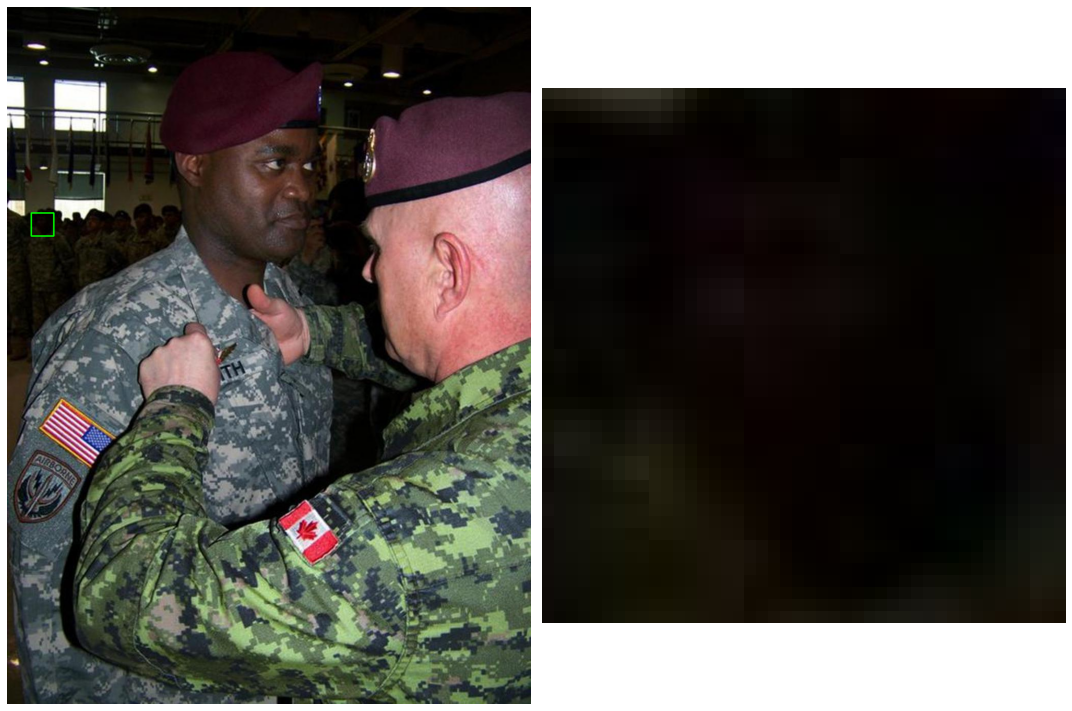

-1
Break


In [16]:
mark_up_dataset(val_mat)

### crop_faces_from_file("")

In [17]:
def crop_faces_from_file(file_path : str):
    with open(path_to_gender_marks_txts + file_path, 'r') as f:
        raw_data = f.readlines()
        data = list(map(lambda x: x.replace('\n', '').strip(), raw_data))
        original_image_path = path_to_all_images + data[0]
        image = cv2.imread(original_image_path)
        for i in (1, len(data)):
            raw_string = data[i]
            

In [43]:
df = pd.read_pickle(path_to_gender_marks + '40_Gymnastics_Gymnastics_40_521.pkl')
df

,Sex,Coords,FaceName
0,m,"[219, 69, 331, 226]",40_Gymnastics_Gymnastics_40_521_0.jpg
1,m,"[291, 395, 407, 531]",40_Gymnastics_Gymnastics_40_521_1.jpg
2,m,"[463, 276, 585, 443]",40_Gymnastics_Gymnastics_40_521_2.jpg
3,m,"[617, 63, 726, 184]",40_Gymnastics_Gymnastics_40_521_3.jpg
